## Data Preparation and Transformation

The code in this section is responsible for loading, processing, and transforming the data sets for USDT, USDC, and DAI. It includes functions for reading the transaction data, filtering out exchange-related transactions, and aggregating the data for analysis. 

**Note to readers:** If you're here for the analysis insights, feel free to skip to the **Analysis Section**.


In [1]:
import pandas as pd
cex = pd.read_csv('./data/cex.csv')
USDC = 'USDC'
USDT = 'USDT'
DAI = 'DAI'

def load_files(stablecoin_name: str):
    # Merge datasets
    df = pd.DataFrame()
    for month in range(1, 11): #until 11 for October'23
        file_name = f'{stablecoin_name}_2023.{month:02d}-.csv'
        current_df = pd.read_csv(f'../data/2023/{stablecoin_name}/{file_name}')
        df = pd.concat([df, current_df], ignore_index=True)
    print(f'✅ {stablecoin_name} files successfully loaded.')
    return df

def transform_data(df, stablecoin_name: str):
    # Exclude txns where `to` is a CEX
    mask = df['to'].isin(cex['address'])
    df_nodex = df[~mask]

    # Filter for retail transactions (value between 1 and 10000)
    retail_mask = df_nodex['value'].between(1, 10000)
    df_retail = df_nodex[retail_mask]

    # Group by 'date' and perform the aggregations
    agg_df = df_nodex.groupby('date')['value'].agg(['sum']).reset_index()
    retail_agg_df = df_retail.groupby('date')['value'].agg(['sum']).reset_index()

    # Count unique 'from' addresses
    wallets = df_nodex.groupby('date')['from'].nunique().rename('total_wallets')
    retail_wallets = df_retail.groupby('date')['from'].nunique().rename('retail_wallets')

    # Merge the aggregated data with the unique wallets count
    df_merged = pd.merge(wallets, agg_df, on='date', how='left')
    df_merged = pd.merge(df_merged, retail_wallets, on='date', how='left')
    df_merged = pd.merge(df_merged, retail_agg_df, on='date', how='left', suffixes=('', '_retail'))

    # Rename columns
    df_merged.rename(columns={'sum': 'total_vol', 'sum_retail': 'retail_vol'}, inplace=True)

    # Add asset type
    df_merged['asset'] = stablecoin_name

    # Format 'wallets' and 'retail_wallets' column with thousands comma
    df_merged['total_wallets'] = df_merged['total_wallets'].apply(lambda x: f"{x:,}")
    df_merged['retail_wallets'] = df_merged['retail_wallets'].apply(lambda x: f"{x:,}")

    # Format 'sum' and 'sum_retail' to two decimals in billions
    df_merged['total_vol'] = df_merged['total_vol'].apply(lambda x: f"{x / 1_000_000_000:,.1f}b")
    df_merged['retail_vol'] = df_merged['retail_vol'].apply(lambda x: f"{x / 1_000_000_000:,.1f}b")

    # Format the date as 'YYYY-MM'
    df_merged['date'] = pd.to_datetime(df_merged['date']).dt.to_period('M')

    return df_merged

In [2]:
# Load data
df_usdt = load_files(USDT)
df_usdc = load_files(USDC)
df_dai = load_files(DAI)

✅ USDT files successfully loaded.
✅ USDC files successfully loaded.
✅ DAI files successfully loaded.


In [3]:
# Transform data
df_usdt_unique = transform_data(df_usdt, USDT)
df_usdc_unique = transform_data(df_usdc, USDC)
df_dai_unique = transform_data(df_dai, DAI)

In [4]:
# Define the charts
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
%matplotlib inline
sns.set_theme(style="darkgrid")

# Concatenate and load the DataFrames
combined_df = pd.concat([df_usdt_unique, df_usdc_unique, df_dai_unique])

# If 'date' is of PeriodDtype, convert to Timestamp; else,  convert it to datetime
if isinstance(combined_df['date'].dtype, pd.PeriodDtype):
    combined_df['date'] = combined_df['date'].dt.to_timestamp()
elif not pd.api.types.is_datetime64_any_dtype(combined_df['date']):
    combined_df['date'] = pd.to_datetime(combined_df['date'])

# Remove commas and convert to integer
combined_df['total_wallets'] = combined_df['total_wallets'].str.replace(',', '').astype(int)
combined_df['total_vol'] = combined_df['total_vol'].str.replace('b', '').str.replace(',', '').astype(float) * 1_000_000_000


def show_lineplot_wallets():
    # Plot the line graph
    sns.lineplot(data=combined_df, x='date', y='total_wallets', hue='asset')

    plt.title('Total Wallets Over Time by Stablecoin')
    plt.xlabel('Period')
    plt.ylabel('Total Wallets')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 1e-3:.0f}K')) # in thousands
    plt.xticks(rotation=45)  # Rotate the x-axis labels if needed
    plt.show()

def show_lineplot_volume():
    # Plot the line graph
    sns.lineplot(data=combined_df, x='date', y='total_vol', hue='asset')

    plt.title('Total Volume Over Time by Stablecoin')
    plt.xlabel('Period')
    plt.ylabel('Total Volume')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / 1e9:.0f}b'))
    plt.xticks(rotation=45)  # Rotate the x-axis labels if needed
    plt.show()

<a id="analysis-section"></a>
## Stablecoin Transaction Analysis: Volume and Wallet Count

### Analysis Objective

The primary goal of this analysis is to estimate the monthly active users of stablecoins, serving as a proxy for the engagement in the Decentralized Finance (DeFi) space.


### Methodological Considerations:

- The wallet count is derived from `sender` addresses involved in Transfer events for USDT, USDC, or DAI.
- Each wallet is counted only once per month, regardless of the number of transactions it participates in.
- Retail accounts and transaction volumes are identified based on transfers that involve assets valued between 1 and 10,000 units.
- Centralized Exchange (CEX) wallets are excluded from the count. However, External Owned Accounts (EOAs) that interact with CEX addresses are included. The implications are as follows:
  - **Deposits to a CEX**: This involves two steps in the transaction process:
    - Transaction 1: An address A sends an asset to the CEX address B. Here, address A is counted in the analysis.
    - Transaction 2: The CEX address B typically moves the asset to a CEX-operated proxy address C. In this step, address B is excluded from the analysis.
  - **Withdrawals from a CEX**: This involves a single step:
    - Transaction 1: The CEX proxy address C sends the asset to an EOA A. Address A is counted in the analysis even if it has not been previously identified as making a deposit.

### USDT Transfer Analysis

In [5]:
print(f'\nAmount of USDT transfers: {len(df_usdt.index):,}')
print(f'Average unique total wallets: {df_usdt_unique['total_wallets'].str.replace(',', '').astype(int).mean():,}')
print(f'Unique total wallets and volume:\n\n{df_usdt_unique.to_string(index=False)}')


Amount of USDT transfers: 41,083,882
Average unique total wallets: 603,336.3
Unique total wallets and volume:

   date total_wallets total_vol retail_wallets retail_vol asset
2023-01       657,244    102.1b        510,061       3.2b  USDT
2023-02       613,819     86.4b        478,787       3.4b  USDT
2023-03       742,239    164.4b        606,888       4.4b  USDT
2023-04       536,089     83.7b        495,053       3.5b  USDT
2023-05       530,384     82.8b        491,461       3.5b  USDT
2023-06       591,100    105.7b        525,179       3.1b  USDT
2023-07       538,687     81.4b        467,046       3.2b  USDT
2023-08       559,354     89.9b        498,859       3.2b  USDT
2023-09       603,663     72.8b        545,331       2.9b  USDT
2023-10       660,784     85.5b        598,138       3.5b  USDT


### USDC Transfer Analysis

In [6]:
print(f'\nAmount of USDC transfers: {len(df_usdc.index):,}')
print(f'Average unique total wallets: {df_usdc_unique['total_wallets'].str.replace(',', '').astype(int).mean():,}')
print(f'Unique total wallets and volume:\n\n{df_usdc_unique.to_string(index=False)}')


Amount of USDC transfers: 18,474,834
Average unique total wallets: 251,870.0
Unique total wallets and volume:

   date total_wallets total_vol retail_wallets retail_vol asset
2023-01       317,275    454.0b        243,776       2.4b  USDC
2023-02       289,544    279.4b        237,224       2.8b  USDC
2023-03       368,885    387.1b        293,098       3.0b  USDC
2023-04       225,445    142.2b        203,349       1.9b  USDC
2023-05       198,411    103.2b        178,742       1.6b  USDC
2023-06       232,569    165.2b        202,912       1.5b  USDC
2023-07       230,410    131.9b        200,936       1.6b  USDC
2023-08       210,819    143.2b        184,288       1.5b  USDC
2023-09       206,016    115.6b        179,977       1.3b  USDC
2023-10       239,326    139.6b        212,006       1.7b  USDC


### DAI Transfer Analysis

In [7]:
print(f'\nAmount of DAI transfers: {len(df_dai.index):,}')
print(f'Average unique total wallets: {df_dai_unique['total_wallets'].str.replace(',', '').astype(int).mean():,}')
print(f'Unique total wallets and volume:\n\n{df_dai_unique.to_string(index=False)}')


Amount of DAI transfers: 2,201,031
Average unique total wallets: 31,732.8
Unique total wallets and volume:

   date total_wallets total_vol retail_wallets retail_vol asset
2023-01        42,902     20.1b         35,922       0.3b   DAI
2023-02        33,077     20.4b         27,938       0.3b   DAI
2023-03        49,107     57.9b         39,020       0.4b   DAI
2023-04        27,251     27.8b         23,336       0.2b   DAI
2023-05        31,365     23.4b         27,786       0.2b   DAI
2023-06        28,428     29.2b         23,937       0.2b   DAI
2023-07        24,934     53.5b         21,046       0.2b   DAI
2023-08        27,447     43.7b         22,471       0.2b   DAI
2023-09        25,259     43.9b         21,561       0.2b   DAI
2023-10        27,558    111.7b         23,575       0.2b   DAI


## Stablecoin Usage Trends

This section visualizes the trends in stablecoin usage over time. The charts below break down the total number of wallets and the total volume of transactions for USDT, USDC, and DAI, providing insights into the adoption rates and transactional throughput of these stablecoins.


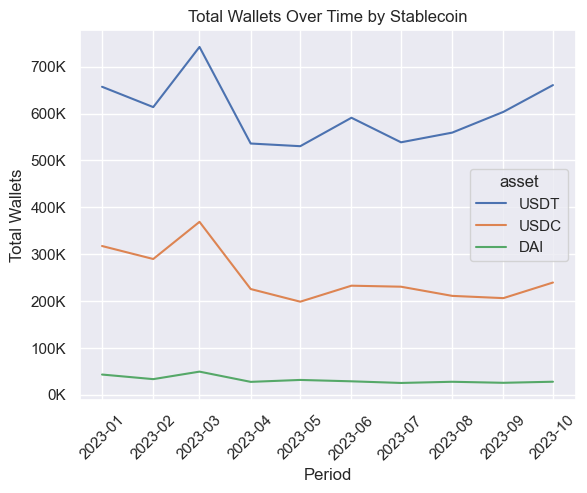

In [8]:
show_lineplot_wallets()

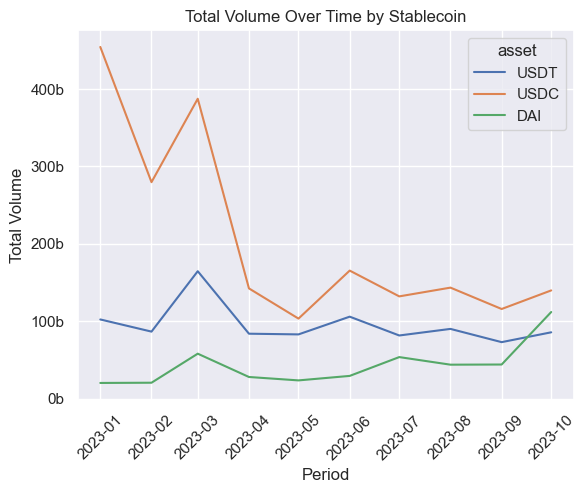

In [9]:
show_lineplot_volume()